In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.96,27.06,26.62,27.05,32165978.0,122840.0,26.88
2016-01-05 05:00:00+00:00,INTC,27.02,27.05,26.68,26.92,17905707.0,87505.0,26.85
2016-01-06 05:00:00+00:00,INTC,26.46,26.67,26.10,26.32,26939523.0,121984.0,26.39
2016-01-07 05:00:00+00:00,INTC,25.68,26.26,25.33,25.33,41368839.0,163862.0,25.63
2016-01-08 05:00:00+00:00,INTC,25.53,25.64,25.01,25.07,32404640.0,142641.0,25.31


<Axes: xlabel='timestamp'>

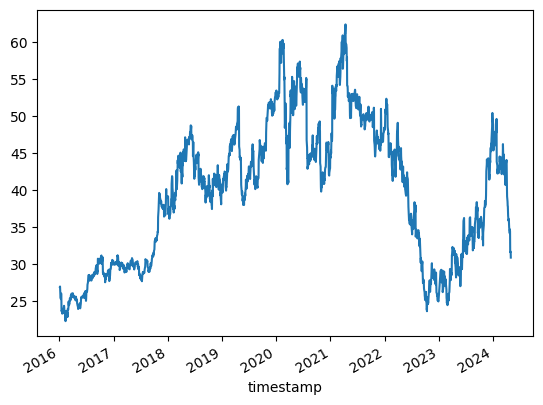

In [2]:
data["open"].plot()

In [3]:
data["sma"] = data["close"].rolling(window=20).mean() # simple moving avrage 
data["sd"] = data["close"].rolling(window=20).std()

data["ub"] = data["sma"] + 2 * data["sd"]
data["lb"] = data["sma"] - 2 * data["sd"]

<Axes: xlabel='timestamp'>

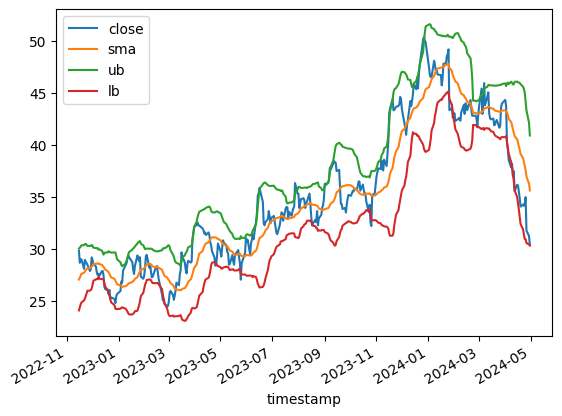

In [4]:
data.iloc[-365:][["close", "sma", "ub", "lb"]].plot()

In [5]:
split_prc = 0.3
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

2095 628 1467


In [6]:
from numpy import ndarray
from pandas import DataFrame

from cira.strategy import back_test
from tqdm import tqdm


class BollingStartegy(cira.strategy.Strategy):

    def __init__(self, sma_window = 20, standard_deviation = 2, risk=0.1) -> None:
        super().__init__(name="Bolling")
        self.sma_window = sma_window
        self.standard_deviation = standard_deviation
        self.risk = risk 
        self.allocation = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray: 
        _feature_data = feature_data.copy()
        _feature_data["sma"] = _feature_data["open"].rolling(window=self.sma_window).mean() # simple moving avrage 
        _feature_data["sd"] =  _feature_data["open"].rolling(window=self.sma_window).std()

        _feature_data["ub"] =  _feature_data["sma"] + self.standard_deviation * _feature_data["sd"]
        _feature_data["lb"] =  _feature_data["sma"] - self.standard_deviation * _feature_data["sd"]

        _all = np.array([0])
        if len(_feature_data) < self.sma_window:
            pass 

        elif prices.iloc[-1].values[0] >= _feature_data.iloc[-1]["ub"]:
            _all = np.array([-1*portfolio[-1]*self.risk])

        elif prices.iloc[-1].values[0] <= _feature_data.iloc[-1]["lb"]:
            _all = np.array([int((cash*self.risk))//prices.iloc[-1].values[0]])

        self.allocation.append(_all)
        return _all.astype(float)
                


    def fit(self, featrue_data: DataFrame, sma_windows = [10, 20, 30], standard_deviations = [1,2,3], risk_lvls=[0.1, 0.2, 0.3], capital=10_000):
        best_prof = 0 
        best_sma = 20
        best_std = 2
        risk = 0.1
        for r in tqdm(risk_lvls):
            for sma_w in sma_windows: 
                for std in standard_deviations: 
                    strat = BollingStartegy(sma_w, std, risk=r)
                    bt = back_test(strat, featrue_data, featrue_data["close"].to_frame(), capital) 
                    prof = bt[strat.name].values[-1] - capital 
                    if prof > best_prof: 
                        best_sma = sma_w
                        best_std = std
                        best_prof = prof
                        risk = r

        print(f"sma:{best_sma}, std:{best_std} @ risk {risk}, portfolio change {best_prof:.2f}$")

        self.sma_window = best_sma
        self.standard_deviation = best_std
        self.risk = risk
        return self
                


In [7]:
strat = BollingStartegy()
start = strat.fit(train_data, sma_windows=list(range(10,60,10)), standard_deviations=list(range(1,6)), risk_lvls=[i/10 for i in range(1,4)], capital=100_000)

100%|██████████| 3/3 [01:13<00:00, 24.65s/it]

sma:20, std:1 @ risk 0.3, portfolio change 44914.77$


Delta: 44722.09$


<Axes: xlabel='timestamp'>

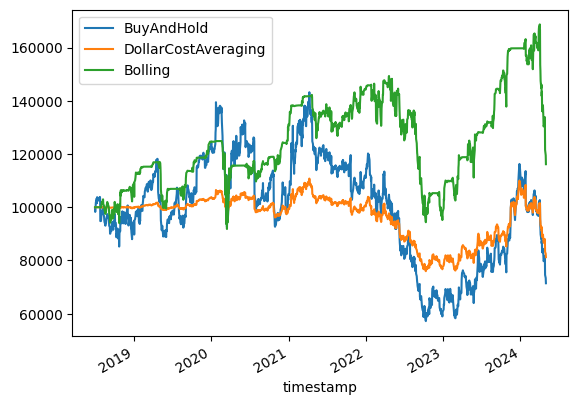

In [8]:
bt = cira.strategy.multi_strategy_backtest([cira.strategy.ByAndHold(), cira.strategy.DollarCostAveraging(1), strat], test_data, test_data["close"].to_frame(), 100_000)
print(f"Delta: {bt[strat.name].values[-1] - bt['BuyAndHold'].values[-1]:.2f}$")
bt.plot()

<Axes: xlabel='timestamp'>

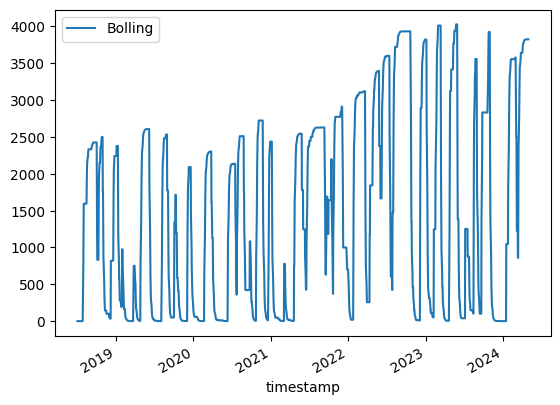

In [9]:
pd.DataFrame({strat.name:np.array(strat.allocation).cumsum()}, index=test_data.index[0:]).plot()